# DataLoaders
> The `timm` DataLoaders that are a bit different than the `torch.utils.data.DataLoader` and a little bit faster. Let's explore them here.

The simplest way to create a dataloader in `timm` is to call the `create_loader` function in `timm.data.loader`. It expects a `dataset` object, an `input_size` parameter and finally a `batch_size`. Everything else is preset for us to make things easy. Let's see a quck example on how to create dataloaders using `timm`. 

## Example Usage

In [3]:
# directory structure of data

!tree ../../imagenette2-320/ -d

../../imagenette2-320/
├── train
│   ├── n01440764
│   ├── n02102040
│   ├── n02979186
│   ├── n03000684
│   ├── n03028079
│   ├── n03394916
│   ├── n03417042
│   ├── n03425413
│   ├── n03445777
│   └── n03888257
└── val
    ├── n01440764
    ├── n02102040
    ├── n02979186
    ├── n03000684
    ├── n03028079
    ├── n03394916
    ├── n03417042
    ├── n03425413
    ├── n03445777
    └── n03888257

22 directories


In [2]:
# create dataset first
from timm.data.dataset import ImageDataset

dataset = ImageDataset('../../imagenette2-320/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=426x320 at 0x7F8379C26190>, 0)

Great, so we have created our dataset. This `ImageDataset` in `timm` is very similar to [torchvision.datasets.ImageFolder](https://pytorch.org/vision/0.8/datasets.html#torchvision.datasets.ImageFolder) with some nice added features. Let's visualize the first image in our dataset. As expected, it's an image of a tench! ;)

> NOTE: By default the dataset created above is for the train folder, thus we can refer to it as the train dataset. 

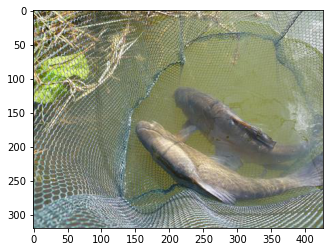

In [3]:
from matplotlib import pyplot as plt

# visualize image
plt.imshow(dataset[0][0])

Let's now create our **DataLoader**.

In [4]:
from timm.data.loader import create_loader

try:
    # only works if gpu present on machine
    train_loader = create_loader(dataset, (3, 224, 224), 4)
except:
    train_loader = create_loader(dataset, (3, 224, 224), 4, use_prefetcher=False)

Here, you might ask why do we have a `try-except` block above? What's the difference between the first `train_loader` and the second one? What is `use_prefetcher` argument and what does it do? 

### Prefetch loader

Internally, `timm` has a class called `PrefetchLoader`. And by default, we use this prefetch loader to create our data loader. But, it only works on GPU enabled machines. Since, GPUs are available for me, the `train_loader` for me is an instance of this `PrefetchLoader` class. 

In [5]:
train_loader

> NOTE: If you are running this notebook a CPU-only machine, the `train_loader` would be an instance of `torch.utils.dataloader`.

Let's now see what does this `PrefetchLoader` do? All the interesting bits happen inside the `__iter__` method of this class. 

```python 
    def __iter__(self):
        stream = torch.cuda.Stream()
        first = True

        for next_input, next_target in self.loader:
            with torch.cuda.stream(stream):
                next_input = next_input.cuda(non_blocking=True)
                next_target = next_target.cuda(non_blocking=True)
                if self.fp16:
                    next_input = next_input.half().sub_(self.mean).div_(self.std)
                else:
                    next_input = next_input.float().sub_(self.mean).div_(self.std)
                if self.random_erasing is not None:
                    next_input = self.random_erasing(next_input)

            if not first:
                yield input, target
            else:
                first = False

            torch.cuda.current_stream().wait_stream(stream)
            input = next_input
            target = next_target

        yield input, target
```

Let's try and understand what's actually going on? All we need to know is about `cuda.stream`s to be able to understand this `__iter__` method inside `PrefetchLoader`. 

From the [documentation](https://pytorch.org/docs/stable/notes/cuda.html#cuda-streams) available on PyTorch: 

```markdown
A CUDA stream is a linear sequence of execution that belongs to a specific device. You normally do not need to create one explicitly: by default, each device uses its own “default” stream.

Operations inside each stream are serialized in the order they are created, but operations from different streams can execute concurrently in any relative order, unless explicit synchronization functions (such as synchronize() or wait_stream()) are used.


When the “current stream” is the default stream, PyTorch automatically performs necessary synchronization when data is moved around. However, when using non-default streams, it is the user’s responsibility to ensure proper synchronization.
```

In simple words, each CUDA device can have it's own "stream" that is a sequence of commands to be run in order. But, doesn't mean that all streams (if multiple CUDA devices exist) are in sync with each other. It could be that while command-1 is running on 1st CUDA device's "stream", command-3 could be running on 2nd CUDA device's "stream".

**But, how is this relevant? Can 'stream's be used to make our data loader faster?**

Ofcourse! That is the whole point! Basically the key idea behind the `PrefetchLoader` in Ross's words is this: 

```
"The prefetching with async cuda transfer helps a little to reduce likelihood of the batch transfer to GPU stalling by (hopefully) initiating it sooner and giving it more flexibility to operate in its own cuda stream concurrently with other ops."
```

Basically, we are performing the "moving to CUDA" step inside a device's own "stream" instead of the default stream. Which means that this step can be performed asynchronously while some other operations might be happening on the CPU or in the default "stream". This helps speed things up a little bit as now data is available on `CUDA` to be passed through the model faster. 

And that's what's going inside the `__iter__` method. 

For the first batch, we iterate through the loader as we would have normally in `torch.utils.data.DataLoader`, and return the `input`, `target`. 

But, for every batch onwards - 
We first instantiate a "stream" for CUDA device using `with torch.cuda.stream(stream):`, next, we perform the `CUDA` transfer inside this device's own "stream" in an asynchronus manner, and yielf this `next_input` and `next_target`. 

Thus, every time we iterate through the data loader, we actually returned a prefetched `input` and `target`, therefore, the name `PrefetchLoader`. 